In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
from BERTweet.TweetNormalizer import normalizeTweet
from tqdm import tqdm
import numpy as np
from sklearn.neural_network import MLPClassifier
import pickle

bertweet = AutoModel.from_pretrained("vinai/bertweet-large")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

#https://github.com/VinAIResearch/BERTweet
#https://huggingface.co/docs/transformers/model_doc/bertweet

/home/kims90/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of

In [2]:

f_train = open("../tweeteval/datasets/sentiment/train_text.txt", "r")
train_text = f_train.read().split("\n")
train_text = train_text[:-1]

f_text = open("../tweeteval/datasets/sentiment/test_text.txt", "r")
test_text = f_text.read().split("\n")
test_text = test_text[:-1]

l_train = open("../tweeteval/datasets/sentiment/train_labels.txt", "r")
train_label = l_train.read().split("\n")
train_label = train_label[:-1]

l_test = open("../tweeteval/datasets/sentiment/test_labels.txt", "r")
test_label = l_test.read().split("\n")
test_label = test_label[:-1]

#https://www.w3schools.com/python/python_file_open.asp

In [3]:
#get train features

train_features = []

for i in tqdm(range(len(train_text))):
    line = normalizeTweet(train_text[i])
    input_ids = torch.tensor([tokenizer.encode(line)])

    with torch.no_grad():
        features = bertweet(input_ids)
        train_features.append(features)

100%|██████████| 45615/45615 [46:00<00:00, 16.53it/s]


In [4]:
#test features
import torch.nn.functional as F
test_features = []

for i in tqdm(range(len(test_text))):
    line = normalizeTweet(test_text[i])
    input_ids = torch.tensor([tokenizer.encode(line)])

    with torch.no_grad():
        try:
            features = bertweet(input_ids)
            test_features.append(features)
        except RuntimeError:
            print("remove index: ", i)


100%|██████████| 12284/12284 [12:19<00:00, 16.62it/s]


In [5]:
train_features_2 = []

for i in train_features:
    train_features_2.append(torch.flatten(i["pooler_output"]).numpy())


clf = MLPClassifier().fit(train_features_2, train_label)

#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [6]:
filename = 'saveMLP.sav'

pickle.dump(clf, open(filename, 'wb'))
#https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

In [7]:
test_features_2 = []

for i in test_features:
    test_features_2.append(torch.flatten(i["pooler_output"]).numpy())


clf.predict(test_features_2)

array(['1', '1', '0', ..., '0', '0', '2'], dtype='<U1')

In [8]:
clf.score(test_features_2, test_label)

0.6252035167697818

In [9]:
from sklearn.metrics import confusion_matrix

true_label = test_label
pred_label = clf.predict(test_features_2)

confusion_matrix(true_label, pred_label)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

array([[3132,  691,  149],
       [1972, 3155,  810],
       [ 292,  690, 1393]])

[[0.78851964 0.17396777 0.03751259]
 [0.33215429 0.53141317 0.13643254]
 [0.12294737 0.29052632 0.58652632]]


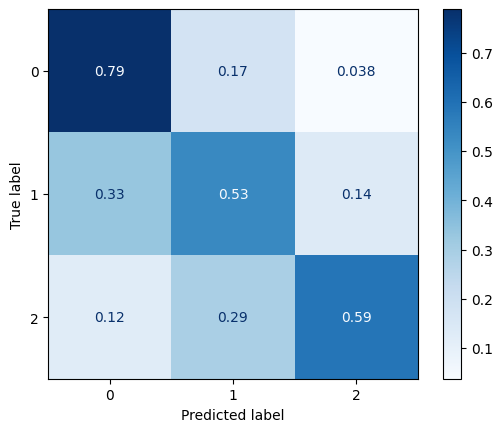

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


disp = ConfusionMatrixDisplay.from_predictions(
    true_label,
    pred_label,
    cmap=plt.cm.Blues,
    normalize='true',

)



print(disp.confusion_matrix)
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

[[0.78851964 0.17396777 0.03751259]
 [0.33215429 0.53141317 0.13643254]
 [0.12294737 0.29052632 0.58652632]]


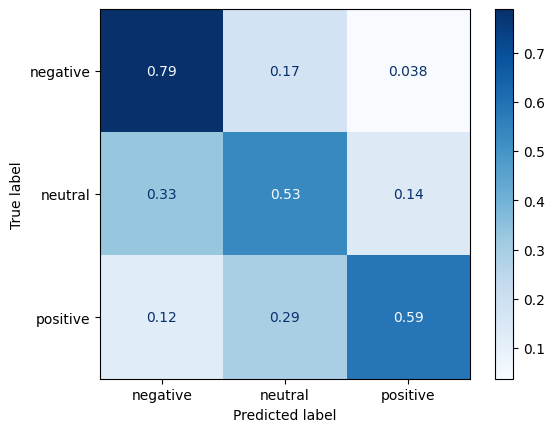

In [11]:
disp = ConfusionMatrixDisplay.from_predictions(
    true_label,
    pred_label,
    display_labels=['negative', 'neutral', 'positive'],
    cmap=plt.cm.Blues,
    normalize='true',

)



print(disp.confusion_matrix)

In [12]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(true_label, pred_label)
print(cf_matrix)

from sklearn.metrics import classification_report
print(classification_report(true_label, pred_label))

[[3132  691  149]
 [1972 3155  810]
 [ 292  690 1393]]
              precision    recall  f1-score   support

           0       0.58      0.79      0.67      3972
           1       0.70      0.53      0.60      5937
           2       0.59      0.59      0.59      2375

    accuracy                           0.63     12284
   macro avg       0.62      0.64      0.62     12284
weighted avg       0.64      0.63      0.62     12284

